In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import clip
import re
import time
import yaml
from matplotlib import pyplot as plt
import pandas as pd
from sentence_transformers import SentenceTransformer
from networks import SCLIPNN

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Loading Models")
clip_model, preprocess = clip.load("ViT-B/32", device=device)
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

Loading Models


In [3]:
#Our sentences we like to encode
dirname = 'europarl/'
train_path = 'train_sentences.txt'
test_path = 'test_sentences.txt'
valid_path = 'valid_sentences.txt'
train_filename = dirname + '/' + train_path
test_filename = dirname + '/' + test_path
valid_filename = dirname + '/' + valid_path

In [4]:
train_sentences = []
with open(train_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        train_sentences.append(line)
N = len(train_sentences)
print("Number of sentences to train: {}".format(N))

Number of sentences to train: 5000


In [5]:
valid_sentences = []
with open(valid_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        valid_sentences.append(line)
N = len(valid_sentences)
print("Number of sentences to valid: {}".format(N))

Number of sentences to valid: 1000


In [6]:
regex = [r"[^A-Za-z0-9]+|[a-zA-Z][0-9]", r"(?<!\d)[0]\d*(?!\d)", r"\s+", r"[0-9]+"]
for r in regex:
    train_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), train_sentences))
    valid_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), valid_sentences))
train_text = clip.tokenize(train_sentences).to(device)
valid_text = clip.tokenize(valid_sentences).to(device)

In [7]:
print("CLIP encoding...")
with torch.no_grad():
    train_clip_embeddings = clip_model.encode_text(train_text)
    valid_clip_embeddings = clip_model.encode_text(valid_text)

CLIP encoding...


In [8]:
print("SBERT encoding...")
with torch.no_grad():  
    train_sbert_embeddings = torch.from_numpy(sbert_model.encode(train_sentences))
    valid_sbert_embeddings = torch.from_numpy(sbert_model.encode(valid_sentences))

SBERT encoding...


In [9]:
print("-"*10)
for sentence, train_clip_embedding, train_sbert_embedding in zip(train_sentences[:1], train_clip_embeddings[:1], train_sbert_embeddings[:1]):
    print("Sentence:", sentence)
    input_size = train_sbert_embedding.size()[0]    
    print("Sbert Embedding: ", input_size)
    print("Clip Embedding: ", train_clip_embedding.size()[0])
    print("-"*10)

----------
Sentence: I declare resumed the session of the European Parliament adjourned on Friday   December   and I would like once again to wish you a happy new year in the hope that you enjoyed a pleasant festive period 
Sbert Embedding:  384
Clip Embedding:  512
----------


In [16]:
print("Creating Models to train...")
NN_500 = SCLIPNN(input_size, 500).to(device)
NN_550 = SCLIPNN(input_size, 550).to(device)
NN_600 = SCLIPNN(input_size, 600).to(device)
NN_650 = SCLIPNN(input_size, 650).to(device)
NN_700 = SCLIPNN(input_size, 700).to(device)
NN_750 = SCLIPNN(input_size, 750).to(device)
NN_800 = SCLIPNN(input_size, 800).to(device)
NN_850 = SCLIPNN(input_size, 850).to(device)
models = {'NN500':NN_500, 'NN550':NN_550,
          'NN600':NN_600, 'NN650':NN_650,
          'NN700':NN_700, 'NN750':NN_750,
          'NN800':NN_800, 'NN850':NN_850}

Creating Models to train...


In [17]:
with open("config.yml", "r") as ymlfile:
    cfg = yaml.safe_load(ymlfile)
params = cfg["training"]

def train(model, train_sbert_embeddings, train_clip_embeddings, 
          valid_sbert_embeddings, valid_clip_embeddings, epochs=params["epochs"], print_every=params["print_every"]):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)    
    train_losses = []
    valid_losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times
        train_loss = 0.0
        model.train()
        for inputs, labels in zip(train_sbert_embeddings, train_clip_embeddings):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output.to(float), labels.to(float))       
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
        train_losses.append(train_loss)
        
        valid_loss = 0.0
        model.eval()
        for inputs, labels in zip(valid_sbert_embeddings, valid_clip_embeddings):
            inputs = inputs.to(device)
            labels = labels.to(device)
            target = model(inputs)
            loss = criterion(target.to(float), labels.to(float))
            valid_loss += loss.item()
        valid_losses.append(valid_loss)
        if (epoch % print_every == 0) or (epoch == epochs - 1):
            print("Epoch {}. Train Loss: {}. Valid Loss: {}".format(epoch, train_loss, valid_loss))
    
    return train_losses, valid_losses

In [18]:
model_train_losses = []
model_valid_losses = []
final_loss = []
training_time = []
for name, model in models.items():
    start_time = time.time()
    print('Training model {}'.format(name))
    train_loss, valid_loss = train(model, train_sbert_embeddings, train_clip_embeddings, 
                                   valid_sbert_embeddings, valid_clip_embeddings, epochs=30)
    model_train_losses.append(train_loss)
    model_valid_losses.append(valid_loss)
    final_loss.append(round(valid_loss[-1],3))
    end_time = time.gmtime(time.time() - start_time)
    elapsed_time = time.strftime("%H:%M:%S", end_time)
    training_time.append(elapsed_time)
    print('Finished Training from model {}. Elapsed time: {}.'.format(name,elapsed_time))
    print("-"*50)
actual_time = time.strftime("%Y/%m/%d, %H:%M:%S", time.gmtime(time.time()))
print("End of Training Process on {}".format(actual_time))

Training model NN500
Epoch 0. Train Loss: 920.77133885871. Valid Loss: 106.948454609911
Epoch 20. Train Loss: 224.06558108376524. Valid Loss: 47.03598025731387
Epoch 29. Train Loss: 218.8735479474928. Valid Loss: 45.94913832003372
Finished Training from model NN500. Elapsed time: 00:05:45.
--------------------------------------------------
Training model NN750
Epoch 0. Train Loss: 870.4078052131365. Valid Loss: 90.4933139785601
Epoch 20. Train Loss: 221.23491917609428. Valid Loss: 46.43109011224173
Epoch 29. Train Loss: 214.4775367193269. Valid Loss: 45.02713750222412
Finished Training from model NN750. Elapsed time: 00:05:45.
--------------------------------------------------
Training model NN600
Epoch 0. Train Loss: 886.2814886401925. Valid Loss: 97.1636792995106
Epoch 20. Train Loss: 222.81787266498714. Valid Loss: 46.796208708892124
Epoch 29. Train Loss: 216.97250440058244. Valid Loss: 45.58411539240585
Finished Training from model NN600. Elapsed time: 00:05:46.
-------------------

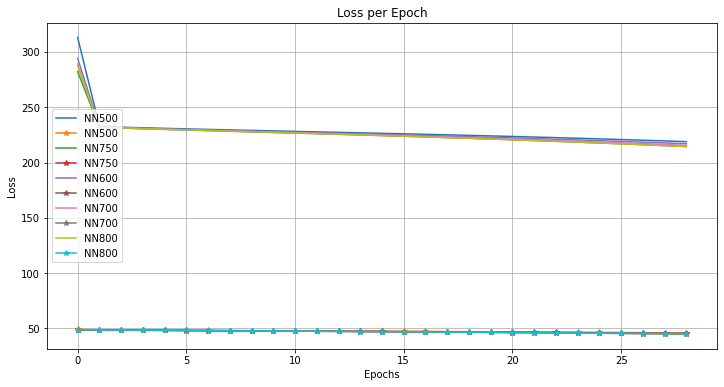

In [19]:
plt.figure(figsize=(12, 6))
for i, (name, model) in enumerate(models.items()):
    plt.plot(model_train_losses[i][1:], label = name)
    plt.plot(model_valid_losses[i][1:], label = name, marker = '*')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.grid()
plt.show()

In [20]:
test_sentences = []
with open(test_filename, mode='rt', encoding='utf-8') as file_object:
    for line in file_object:
        test_sentences.append(line)
N = len(test_sentences)
print("Number of sentences to test: {}".format(N))

Number of sentences to test: 1000


In [21]:
for r in regex:
    test_sentences = list(map(lambda sentence: re.sub(r, " ", sentence), test_sentences))
test_text = clip.tokenize(test_sentences).to(device)

In [22]:
with torch.no_grad():
    test_clip_embeddings = clip_model.encode_text(test_text)

In [23]:
with torch.no_grad():
    test_sbert_embeddings = torch.from_numpy(sbert_model.encode(test_sentences))

In [24]:
def cosin_calculator(targets, predictions):    
    cosines = []
    cos = nn.CosineSimilarity(dim=0, eps=1e-6)
    for tar, pred in zip(targets, predictions):        
        cosine = cos(tar, pred)
        cosines.append(cosine.item())
    return np.array(cosines)

In [25]:
def evaluate(models, test_clip_embeddings, test_sbert_embeddings):
    cosines = []
    euclideans = []
    with torch.no_grad():
        for name, model in models.items():
            sum_cos = 0
            count = 0
            predictions =[]
            if len(test_clip_embeddings) == 0:
                break
            for tclip, tsbert in zip(test_clip_embeddings, test_sbert_embeddings):        
                tclip = tclip.to(device)
                tsbert = tsbert.to(device)
                prediction = model(tsbert)
                predictions.append(prediction)
                sum_cos += np.mean(cosin_calculator(tclip, prediction))
                count += 1
            cosines.append(round(sum_cos/count,3))
            stacked_predictions = torch.stack(predictions)
            euclidean = torch.cdist(test_clip_embeddings.to(float), stacked_predictions.to(float))
            avg_euclidean = torch.mean(euclidean)
            euclideans.append(round(avg_euclidean.item(),3))    
    return cosines, euclideans

In [30]:
print("Evaluating...")
start_time = time.time()
cosines, euclideans = evaluate(models,test_clip_embeddings, test_sbert_embeddings)
end_time = time.gmtime(time.time() - start_time)
evaluation_time = time.strftime("%H:%M:%S", end_time)
print("Evaluation Time: {}".format(evaluation_time))

Evaluating...
Evaluation Time: 00:11:28


In [31]:
data = {"Cosin":cosines, "Euclidean":euclideans, 
        "TrainTime":training_time, "ValLoss":final_loss}
results = pd.DataFrame(data, index=models.keys())

In [32]:
results

,Cosin,Euclidean,TrainTime,ValLoss
NN500,0.310,4.873,00:05:45,45.949
NN750,0.318,4.883,00:05:45,45.027
NN600,0.314,4.878,00:05:46,45.584
NN700,0.316,4.881,00:05:45,45.266
NN800,0.319,4.883,00:05:43,45.028
